### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
%%time

##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 265 ms, sys: 44.3 ms, total: 309 ms
Wall time: 308 ms


In [4]:
dataset.head()

created_date  city_tier first_platform_c first_utm_medium_c  \
0  2021-07-01 00:08:15        1.0           Level0            Level11   
1  2021-07-01 00:16:43        2.0           Level3             Level0   
2  2021-07-01 00:22:20        1.0           Level3             Level0   
3  2021-07-01 00:23:13        1.0           Level1             Level3   
4  2021-07-01 00:28:38        1.0           Level3             Level0   

  first_utm_source_c  total_leads_droppped  referred_lead  app_complete_flag  \
0             Level2                   1.0            0.0                  1   
1             others                   1.0            0.0                  1   
2             Level0                   1.0            0.0                  1   
3             others                   2.0            0.0                  0   
4             Level0                   1.0            0.0                  0   

   assistance_interaction  career_interaction  payment_interaction  \
0                     0.0                 0.0                  0.0   
1                     0.0                 0.0                  0.0   
2                     0.0                 0.0                  0.0   
3                     0.0                 0.0                  0.0   
4                     0.0                 0.0                  0.0   

   social_interaction  syllabus_interaction  
0                 0.0                   0.0  
1                 0.0                   0.0  
2                 0.0                   0.0  
3                 0.0                   0.0  
4                 0.0                   0.0

In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location
import sqlite3
from sqlite3 import Error

def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection("lead_scoring_model_experimentation.db")

2.6.0


In [7]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"

mlflow.set_tracking_uri("http://0.0.0.0:6007")

In [8]:
# setup pycaret 
exp_lead_scoring = setup(data=dataset, target = 'app_complete_flag',  
                   fold_shuffle=True, 
                   session_id = 42,
                   normalize = True, 
                   transformation = True, 
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Lead_scoring_model_experimentation_01',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=True)


Description  \
0                               session_id   
1                                   Target   
2                              Target Type   
3                            Label Encoded   
4                            Original Data   
5                           Missing Values   
6                         Numeric Features   
7                     Categorical Features   
8                         Ordinal Features   
9                High Cardinality Features   
10                 High Cardinality Method   
11                   Transformed Train Set   
12                    Transformed Test Set   
13                      Shuffle Train-Test   
14                     Stratify Train-Test   
15                          Fold Generator   
16                             Fold Number   
17                                CPU Jobs   
18                                 Use GPU   
19                          Log Experiment   
20                         Experiment Name   
21                                     USI   
22                         Imputation Type   
23          Iterative Imputation Iteration   
24                         Numeric Imputer   
25      Iterative Imputation Numeric Model   
26                     Categorical Imputer   
27  Iterative Imputation Categorical Model   
28           Unknown Categoricals Handling   
29                               Normalize   
30                        Normalize Method   
31                          Transformation   
32                   Transformation Method   
33                                     PCA   
34                              PCA Method   
35                          PCA Components   
36                     Ignore Low Variance   
37                     Combine Rare Levels   
38                    Rare Level Threshold   
39                         Numeric Binning   
40                         Remove Outliers   
41                      Outliers Threshold   
42                Remove Multicollinearity   
43             Multicollinearity Threshold   
44             Remove Perfect Collinearity   
45                              Clustering   
46                    Clustering Iteration   
47                     Polynomial Features   
48                       Polynomial Degree   
49                    Trignometry Features   
50                    Polynomial Threshold   
51                          Group Features   
52                       Feature Selection   
53                Feature Selection Method   
54            Features Selection Threshold   
55                     Feature Interaction   
56                           Feature Ratio   
57                   Interaction Threshold   
58                           Fix Imbalance   
59                    Fix Imbalance Method   

                                    Value  
0                                      42  
1                       app_complete_flag  
2                                  Binary  
3                                    None  
4                            (238964, 12)  
5                                   False  
6                                       7  
7                                       4  
8                                   False  
9                                   False  
10                                   None  
11                           (167274, 43)  
12                            (71690, 43)  
13                                   True  
14                                  False  
15                        StratifiedKFold  
16                                     10  
17                                     -1  
18                                  False  
19                                   True  
20  Lead_scoring_model_experimentation_01  
21                                   c8f2  
22                                 simple  
23                                   None  
24                                   mean  
25                                   None  
26                               con

### 4 : Model Experimentation with pycaret

In [9]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

In [10]:
# create a model which gives the highest accuracy

lightgbm = create_model('lightgbm')

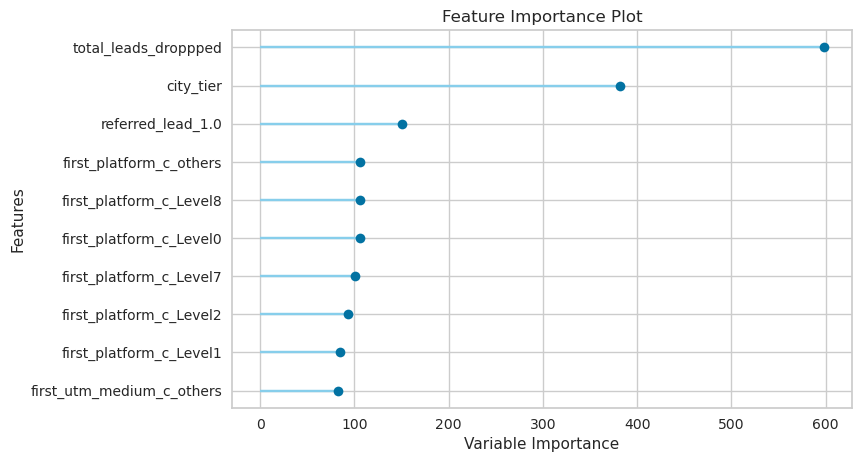

In [11]:
# create feature importance plot
plot_model(lightgbm, plot='feature')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [12]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
cols = ['total_leads_droppped', 'city_tier', 'referred_lead', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c', 'app_complete_flag']
dataset_cols = dataset[cols]

In [13]:
from pycaret.classification import *

exp_lead_scoring = setup(data=dataset_cols, target = 'app_complete_flag',  
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   categorical_features = ['city_tier', 'first_platform_c','first_utm_medium_c', 'first_utm_source_c'],
                   fold_shuffle=True, 
                   session_id = 42,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Lead_scoring_model_experiment_02',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=True)

Description                             Value
0                               session_id                                42
1                                   Target                 app_complete_flag
2                              Target Type                            Binary
3                            Label Encoded                              None
4                            Original Data                       (238964, 7)
5                           Missing Values                             False
6                         Numeric Features                                 1
7                     Categorical Features                                 5
8                         Ordinal Features                             False
9                High Cardinality Features                             False
10                 High Cardinality Method                              None
11                   Transformed Train Set                      (167274, 40)
12                    Transformed Test Set                       (71690, 40)
13                      Shuffle Train-Test                              True
14                     Stratify Train-Test                             False
15                          Fold Generator                   StratifiedKFold
16                             Fold Number                                10
17                                CPU Jobs                                -1
18                                 Use GPU                             False
19                          Log Experiment                              True
20                         Experiment Name  Lead_scoring_model_experiment_02
21                                     USI                              cde9
22                         Imputation Type                            simple
23          Iterative Imputation Iteration                              None
24                         Numeric Imputer                              mean
25      Iterative Imputation Numeric Model                              None
26                     Categorical Imputer                          constant
27  Iterative Imputation Categorical Model                              None
28           Unknown Categoricals Handling                    least_frequent
29                               Normalize                             False
30                        Normalize Method                              None
31                          Transformation                             False
32                   Transformation Method                              None
33                                     PCA                             False
34                              PCA Method                              None
35                          PCA Components                              None
36                     Ignore Low Variance                             False
37                     Combine Rare Levels                             False
38                    Rare Level Threshold                              None
39                         Numeric Binning                             False
40                         Remove Outliers                             False
41                      Outliers Threshold                              None
42                Remove Multicollinearity                              True
43             Multicollinearity Threshold                              0.95
44             Remove Perfect Collinearity                              True
45                              Clustering                             False
46                    Clustering Iteration                              None
47                     Polynomial Features                             False
48                       Polynomial Degree                              None
49                    Trignometry Features                             False
50                    Polynomial Threshold                              None
51                         

In [14]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

In [15]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

lightgbm_fs = create_model('lightgbm')

In [16]:
model_config_without_hp = lightgbm_fs.get_params()

In [17]:
#!pip install optuna

In [18]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

tuned_lgbm_optuna,tuner_1 = tune_model(lightgbm_fs, 
                                   search_library = 'optuna',
                                   fold = 10,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True)

In [19]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm_optuna.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
